Copyright 2022 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Dataset distillation

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/jaxopt/blob/main/docs/notebooks/implicit_diff/dataset_distillation.ipynb)




Dataset distillation [Maclaurin et al. 2015](https://arxiv.org/pdf/1502.03492.pdf), [Wang et al. 2020](https://arxiv.org/pdf/1811.10959.pdf) aims to learn a small synthetic
training dataset such that a model trained on this learned data set achieves
small loss on the original training set.

**Bi-level formulation**

Dataset distillation can be written formally as a bi-level problem, where in the
inner problem we estimate a logistic regression model $x^\star(\theta) \in
\mathbb{R}^{p \times k}$ trained on the distilled images $\theta \in
\mathbb{R}^{k \times p}$, while in the outer problem we want to minimize the
loss achieved by $x^\star(\theta)$ over the training set:

$$\underbrace{\min_{\theta \in \mathbb{R}^{k \times p}} f(x^\star(\theta), X_{\text{tr}}; y_{\text{tr}})}_{\text{outer problem}} ~\text{ subject to }~ x^\star(\theta) \in \underbrace{\text{argmin}_{x \in \mathbb{R}^{p \times k}} f(x, \theta; [k]) + \text{l2reg} \|x\|^2\,}_{\text{inner problem}}$$

where $f(W, X; y) := \ell(y, XW)$, and $\ell$ denotes the multiclass
logistic regression loss, $X_{\text{tr}}, y_{\text{tr}}$ are the samples and
target values in the train set, and $\text{l2reg} = 10^{-1}$ is a regularization
parameter that we found improved convergence.

In [1]:
#@title Imports
%%capture
%pip install jaxopt flax

In [2]:
import itertools
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

# activate TPUs if available
try:
    import jax.tools.colab_tpu
    jax.tools.colab_tpu.setup_tpu()
except (KeyError, RuntimeError):
    print("TPU not found, continuing without it.")

import jax
from jax import numpy as jnp

from jaxopt import GradientDescent
from jaxopt import objective

jax.config.update("jax_platform_name", "cpu")

In [3]:
#@title Load mnist
mnist_train, ds_info = tfds.load(name="mnist", split="train", with_info=True)
images_train = jnp.array([ex['image'].ravel() for ex in tfds.as_numpy(mnist_train)]) / 255.0
labels_train = jnp.array([ex['label'] for ex in tfds.as_numpy(mnist_train)])

mnist_test = tfds.load(name="mnist", split="test")
images_test = jnp.array([ex['image'].ravel() for ex in tfds.as_numpy(mnist_test)]) / 255.0
labels_test = jnp.array([ex['label'] for ex in tfds.as_numpy(mnist_test)])

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [4]:
#@title Inner Problem

# these are the parameters of the logistic regression problem (inner problem)
params = jnp.ones((28 * 28, 10))

# amount of L2 reglarization of the inner problem. This helps both the
# convergence of the inner problem and the computation of the hypergradient
l2reg = 1e-1

inner_loss = objective.l2_multiclass_logreg
gd = GradientDescent(fun=inner_loss, tol=1e-3, maxiter=500)

In [5]:
#@title Outer Problem
rng = jax.random.PRNGKey(0)

# Distilled images (initialized at random, to be learned). These are the
# parameters of the outer problem
distilled_images = jax.random.normal(rng, (10, 28 * 28)) / (28 * 28)
distilled_labels = jnp.arange(10)

In [6]:
# we now construct the outer loss and perform gradient descent on it
def outer_loss(img):
    # inner_sol is the solution to the inner problem, which computes the
    # model trained on the 10 images from distilled_images. This makes
    # the problem bi-level, as the objective depends itself on the solution
    # of an optimization problem  (inner_sol)
    inner_sol = gd.run(params, l2reg, (img, distilled_labels)).params
    return objective.l2_multiclass_logreg(
        inner_sol, 0, (images_train, labels_train))

gd_outer = GradientDescent(fun=outer_loss, tol=1e-3, maxiter=50)

In [7]:
#@title Results
distilled_images = gd_outer.run(distilled_images).params

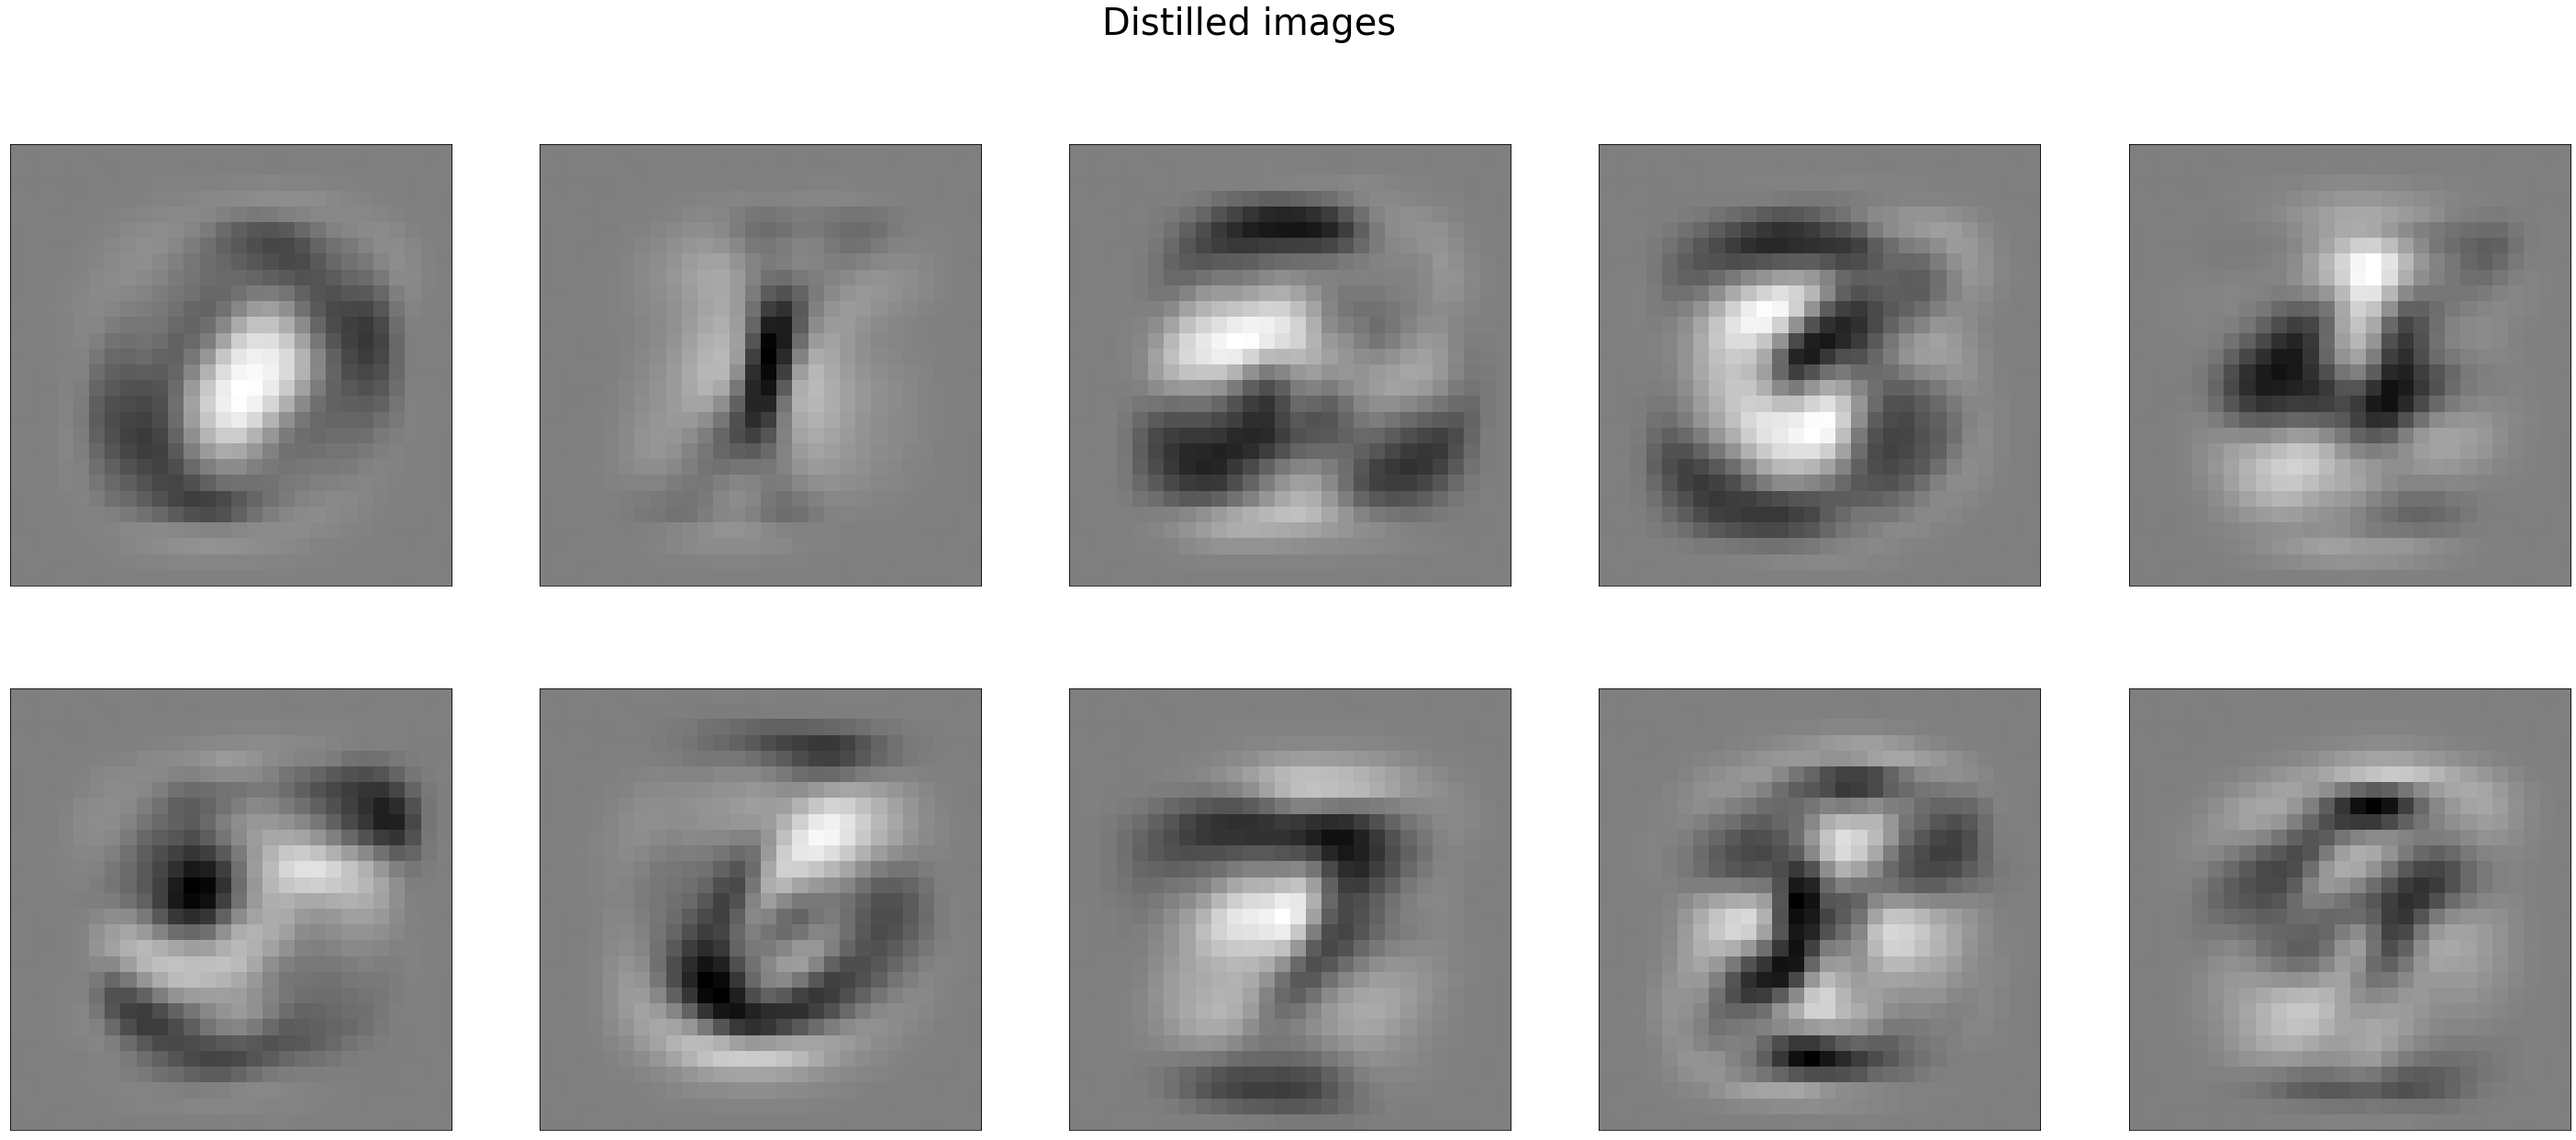

In [8]:
# Plot the learnt images
fig, axarr = plt.subplots(2, 5, figsize=(10 * 5, 2 * 10))
plt.suptitle("Distilled images", fontsize=40)

for k, (i, j) in enumerate(itertools.product(range(2), range(5))):
    img_i = distilled_images[k].reshape((28, 28))
    axarr[i, j].imshow(
        img_i / jnp.abs(img_i).max(), cmap=plt.cm.gray_r, vmin=-1, vmax=1)
    axarr[i, j].set_xticks(())
    axarr[i, j].set_yticks(())
plt.show()